In [1]:
from aeon.datasets import load_classification
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from laplace_hdc_helper import load_dataset
from laplace_hdc_classifier_1d import train_hdc_classifier, test_hdc_classifier
from laplace_hdc_encoder_1d import hdc_encoder
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from scipy.io import savemat, loadmat


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_name = 'WalkingSittingStanding'
try:
    NHDC = loadmat(f'../{dataset_name}_nHD.mat')[f'{dataset_name}_nHD']
except:
    NHDC = range(1000, 5500, 500)
    
NHDC

array([[ 6000.,  7000.,  7000.],
       [ 7000.,  8000.,  8000.],
       [ 8000.,  9000.,  9000.],
       [ 9000., 11000., 10000.],
       [10000., 12000., 11000.],
       [11000., 13000., 13000.],
       [12000., 15000., 14000.],
       [13000., 16000., 15000.],
       [14000., 17000., 16000.],
       [15000., 18000., 18000.],
       [16000., 20000., 19000.]])

In [3]:
# Load dataset
X_train, y_train, metadata = load_classification(dataset_name, return_metadata=True, split='train')
X_test, y_test = load_classification(dataset_name, split='test')
if X_train.shape[0] < 200:
    if X_test.shape[0] >= 200:
        train_size = (X_train.shape[0] + X_test.shape[0]) * 3/4
        x, y = load_classification(dataset_name)
        X_train, y_train = x[:train_size, :], y[:train_size]
        X_test, y_test = x[train_size:, :], y[train_size:]

In [4]:
input_channels = 1
if X_train.ndim == 3:
    input_channels = X_train.shape[1]
seq_length = X_train.shape[-1]
if y_train.dtype == object or isinstance(y_train[0], str):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

In [5]:
X_train.shape

(7352, 3, 206)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, seq_length))
X_test_scaled = scaler.transform(X_test.reshape(-1, seq_length))

if input_channels == 1:
    X_min = X_train_scaled.min(axis=0)
    X_max = X_train_scaled.max(axis=0)
    
    denom = (X_max - X_min)
    denom[denom == 0] = 1   # avoid division by zero
    
    X_train_norm = (X_train_scaled - X_min) / denom
    X_test_norm  = (X_test_scaled  - X_min) / denom
    
    # Optional: clip to [0,1] just in case
    X_train_norm = np.clip(X_train_norm, 0, 1)
    X_test_norm  = np.clip(X_test_norm, 0, 1)
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).unsqueeze(1).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(1).to(device)
else:
    X_min = X_train.min(axis=0)
    X_max = X_train.max(axis=0)
    
    denom = (X_max - X_min)
    denom[denom == 0] = 1   # avoid division by zero
    
    X_train_norm = (X_train - X_min) / denom
    X_test_norm  = (X_test  - X_min) / denom
    
    # Optional: clip to [0,1] just in case
    X_train_norm = np.clip(X_train_norm, 0, 1)
    X_test_norm  = np.clip(X_test_norm, 0, 1)
    # Multichannel → keep original channels
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).to(device)

    

In [7]:
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

num_classes = len(np.unique(y_train))

In [8]:
torch.min(X_test_tensor), torch.max(X_test_tensor), np.unique(y_train)

(tensor(0., device='cuda:0'),
 tensor(1., device='cuda:0'),
 array([0, 1, 2, 3, 4, 5]))

lambda = 0.06277484446763992
618


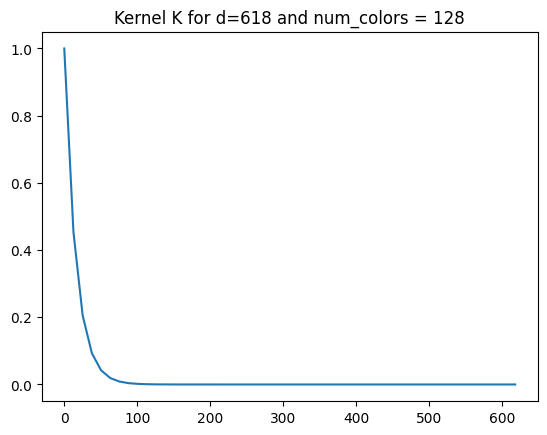

In [9]:
# Determining Lambda from random 1000 samples
bandwidth_parameter = 3 # bandwidth parameter
encoder_mode = 'shift_1d'
classifier_mode="float_sgd"
batch_size = 1024
num_colors = 128

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1).cpu()

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = bandwidth_parameter/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

# Visualize the global kernel
d = train_data[0][0].squeeze().numel()
print(d)
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

In [10]:
hyperdims = np.mean(NHDC, axis=1, dtype=int)
hyperdims

array([ 6666,  7666,  8666, 10000, 11000, 12333, 13666, 14666, 15666,
       17000, 18333])

In [11]:
num_workers = 0
pin_memory=False
n_splits = 20
split_size = len(test_data) // n_splits # 10000 // 20 = 500scales = np.arange(0.2, 1.21, 0.1)
print(split_size)
accuracies = np.zeros((len(hyperdims), n_splits))
num_classes=len(np.unique(y_train))
for i, nHDC in enumerate(hyperdims):
    print(f'Hyperdimension: {nHDC} Started --------------')
    # Train
    for split_idx in tqdm(range(n_splits)):
        indices = list(range(len(test_data)))
        np.random.shuffle(indices)  # or random.shuffle(indices)
        start_idx = split_idx * split_size
        end_idx = start_idx + split_size
        split_indices = indices[start_idx:end_idx]
        split_subset = Subset(test_data, split_indices)
        split_loader = torch.utils.data.DataLoader(split_subset, batch_size=256, shuffle=False,
                                                   num_workers=num_workers, pin_memory=pin_memory)
        encoder = hdc_encoder(d, nHDC, kernel, encoder_mode)
        train_hdc = encoder.encode(train_loader)
        train_loader_hdc = DataLoader(train_hdc,batch_size=512,shuffle=True,num_workers=0,pin_memory=False)
        model = train_hdc_classifier(train_loader_hdc, num_classes, mode=classifier_mode, epochs=10)
        # print(f'Encoding Train Data and Training the Model for nHDC={nHDC} finished')
        # Test
        split_hdc = encoder.encode(split_loader)
        split_loader_hdc = DataLoader(
            split_hdc,
            batch_size=64,
            shuffle=True,
            num_workers=0,
            pin_memory=False
        )
        accuracies[i, split_idx] = test_hdc_classifier(model, split_loader_hdc)*100
    print(f'Hyperdimension: {nHDC} Finished. Average Accuracy over {n_splits} rounds: {np.mean(accuracies[i])}, std: {np.std(accuracies[i])}')


147
Hyperdimension: 6666 Started --------------


100%|██████████| 20/20 [03:50<00:00, 11.52s/it]


Hyperdimension: 6666 Finished. Average Accuracy over 20 rounds: 74.62585034013605, std: 2.626766609021472
Hyperdimension: 7666 Started --------------


100%|██████████| 20/20 [03:51<00:00, 11.56s/it]


Hyperdimension: 7666 Finished. Average Accuracy over 20 rounds: 76.156462585034, std: 2.6650262204012125
Hyperdimension: 8666 Started --------------


100%|██████████| 20/20 [03:52<00:00, 11.65s/it]


Hyperdimension: 8666 Finished. Average Accuracy over 20 rounds: 74.76190476190479, std: 3.2332611260724207
Hyperdimension: 10000 Started --------------


100%|██████████| 20/20 [03:58<00:00, 11.94s/it]


Hyperdimension: 10000 Finished. Average Accuracy over 20 rounds: 74.79591836734694, std: 2.913876315432293
Hyperdimension: 11000 Started --------------


100%|██████████| 20/20 [03:59<00:00, 11.99s/it]


Hyperdimension: 11000 Finished. Average Accuracy over 20 rounds: 76.56462585034012, std: 2.647604715022975
Hyperdimension: 12333 Started --------------


100%|██████████| 20/20 [04:02<00:00, 12.14s/it]


Hyperdimension: 12333 Finished. Average Accuracy over 20 rounds: 76.36054421768708, std: 3.1015857763874792
Hyperdimension: 13666 Started --------------


100%|██████████| 20/20 [04:07<00:00, 12.38s/it]


Hyperdimension: 13666 Finished. Average Accuracy over 20 rounds: 75.13605442176872, std: 2.6124131890234574
Hyperdimension: 14666 Started --------------


100%|██████████| 20/20 [04:06<00:00, 12.35s/it]


Hyperdimension: 14666 Finished. Average Accuracy over 20 rounds: 76.70068027210884, std: 2.8931565710654077
Hyperdimension: 15666 Started --------------


100%|██████████| 20/20 [04:09<00:00, 12.48s/it]


Hyperdimension: 15666 Finished. Average Accuracy over 20 rounds: 75.27210884353742, std: 2.7319087587693907
Hyperdimension: 17000 Started --------------


100%|██████████| 20/20 [04:13<00:00, 12.70s/it]


Hyperdimension: 17000 Finished. Average Accuracy over 20 rounds: 75.27210884353742, std: 3.8976386234253617
Hyperdimension: 18333 Started --------------


100%|██████████| 20/20 [04:17<00:00, 12.86s/it]

Hyperdimension: 18333 Finished. Average Accuracy over 20 rounds: 74.35374149659866, std: 2.609089647723142


In [12]:
np.mean(accuracies, axis=1)

array([74.62585034, 76.15646259, 74.76190476, 74.79591837, 76.56462585,
       76.36054422, 75.13605442, 76.70068027, 75.27210884, 75.27210884,
       74.3537415 ])

In [13]:
savemat(f'{dataset_name}_LaplaceHDC.mat', {f'{dataset_name}_LaplaceHDC': accuracies})